## **Notebook Summary**

### **Purpose**
This notebook evaluates and visualizes the performance of a clinical trial-patient matching system ("trial_matches.json"), comparing system-assigned trial suitability verdicts against curated gold-standard labels.

---

### **Key Steps and Logic**

#### **1. Data Loading**
- Loads:
  - **Gold/reference** patient-trial pairs and scores from `test.tsv`.
  - **Patient queries** and **trial corpus** from `queries.jsonl` and `corpus.jsonl`.
  - **Trial matches** (detailed matching outputs) from `matched/trial_matches.json` (contains verdicts, reasoning about inclusion/exclusion).

#### **2. Flatten & Normalize Trial Matches**
- Iterates through `trial_matches.json` to **flatten nested structures** into a DataFrame:
  - Columns include: `query-id`, `corpus-id`, model trial verdict (`match_verdict`), reasoning, inclusion/exclusion flags, and detailed eligibility explanations.

#### **3. Merge Gold with System Predictions**
- Merges gold-standard pairs (`df_tsv`) with matched verdicts (`df_trial_matches`) by query and trial IDs.
- Ensures **all gold pairs are present**, filling unmatched ones with NaN for later filtering/checks.

#### **4. Label Harmonization**
- Maps system verdicts (“STRONG MATCH”, “POSSIBLE MATCH”, “WEAK MATCH”, “UNSUITABLE”) into numeric label space {0, 1, 2} for comparison:
  - 2: Highly likely ("STRONG MATCH" or "POSSIBLE MATCH")
  - 1: Would consider ("WEAK MATCH")
  - 0: Would not refer ("UNSUITABLE")
- Aligns ground-truth labels from gold file into the same space.

#### **5. Evaluation**
- **Omissions:** Reports count/samples of pairs where there is no system verdict (excluded from scoring).
- **Metrics:**
  - Computes **confusion matrix** (tabular and heatmap) to visualize agreement.
  - Calculates **macro-averaged F1 score** and displays a full classification report (precision/recall per label).
- **Visualization:** Plots the confusion matrix with Seaborn for a clear model performance summary.

#### **6. Inspection & Quality Control**
- Provides options to display merged/evaluated DataFrame (with explanations/reasoning), as well as any omitted/missing rows.

#### **7. Display/Output**
- Configures pandas for wide displays, allowing direct inspection of large slices of merged data and reasoning fields.

---

### **Outputs**
- **Metrics for Model QA:** Confusion matrix, macro F1, precision/recall for each decision level.
- **Visualization:** Color-coded confusion matrix heatmap for rapid error pattern assessment.
- **Inspection:** Full merged DataFrame can be displayed, supporting qualitative analysis via system reasoning and verdicts.

---

### **Intended Use**
- **Model validation and debugging:** Evaluate system-patient-to-trial assignment quality.
- **Insight into errors:** Directly reveals misclassifications and their reasoning by exploring DataFrame rows.
- **Transparent reporting:** Well-suited for sharing system strengths and weaknesses with stakeholders or during clinical IR system development.

---

### **Technical/Architectural Notes**
- **Robust merging:** Ensures all reference pairs are considered, not just those found by the matcher.
- **Extendable:** Can be easily fit for other datasets or more granular scoring/justification analysis.
- **User-friendly:** Designed for rapid exploratory analysis, including straightforward displays for both summary and raw data.

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
import os
import pandas as pd
import json

# Set up paths
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load main input data
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

In [3]:
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

 df_tsv 59 df_queries 2 df_corpus 59


In [4]:
# Glimpse at dataframes:
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())
# display(trial_matches_long.head())

# ---- Now you can proceed with analysis & evaluation below!

,query-id,corpus-id,score
0,sigir-20141,NCT00000492,1
1,sigir-20141,NCT00005127,2
2,sigir-20141,NCT00005485,2
3,sigir-20141,NCT00005757,2
4,sigir-20141,NCT00129233,1


,_id,text
0,sigir-20141,A 58-year-old African-American woman presents ...
1,sigir-201410,A physician is called to see a 67-year-old wom...


,_id,title,metadata
0,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education..."
1,NCT00000492,Beta-Blocker Heart Attack Trial (BHAT),"{'phase': 'Phase 3', 'drugs': '['propranolol']..."
2,NCT00005127,Muscatine Heart Study,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': ..."
3,NCT00005485,Environmental and Genetic Factors That Influen...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': ..."
4,NCT00005757,Racial Variation in ACE--Genetic and Physiolog...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': ..."


In [5]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the JSON as a list of dicts
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flattening loop
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Create DataFrame
df_trial_matches = pd.DataFrame(records)

# Preview
pd.set_option('display.max_colwidth', 200)
display(df_trial_matches.head())

,query-id,corpus-id,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning
0,sigir-20141,NCT02357212,Early Invasive Versus Conservative Therapy in Women With an Acute Coronary Syndrome,60,POSSIBLE MATCH,"The patient presents with symptoms suggestive of acute coronary syndrome, which is the primary condition of interest in the trial. However, the absence of detailed information on cardiac biomarker...",PASS,Patient does not meet any exclusion criteria. The patient's profile does not provide clear evidence of meeting any of the exclusion criteria listed for the trial. There is no mention of ST-elevati...,UNDETERMINED,- Troponin T levels\n- Creatinine kinase MB-isoenzyme levels\n- NT-pro-BNP levels\n- ST-segment depression measurement\n- TIMI risk score\n- Details on cardiac enzyme levels after non-cardiac surg...,None,"The patient presents with symptoms suggestive of acute coronary syndrome (chest pain, nausea, diaphoresis, and mild dyspnea), which aligns with the clinical presentation of non-ST-elevation acute ..."
1,sigir-20141,NCT02608255,A Prospective Pilot Study to Evaluate a New Marker of Ischemia in Chest Pain Triage,None,None,None,PASS,"Patient does not meet any exclusion criteria. The patient's profile does not indicate any of the exclusion criteria such as anticoagulation before blood samples, progressive septic processes, neop...",FAIL,None,"- Subject with compatible symptoms with an acute coronary syndrome, for at least 15 minutes and not older than 3 hours","The patient's chief complaint of episodic pressing/burning anterior chest pain started two days earlier, which exceeds the 3-hour time frame specified in the inclusion criteria. Although the patie..."
2,sigir-20141,NCT00952744,Investigation of the Biomarker Copeptin in Patients With Acute Myocardial Infarction,None,None,None,PASS,"Patient does not meet any exclusion criteria. The patient's symptoms are consistent with ACS, and there is no indication that the symptoms are clearly not the result of ACS, such as penetrating wo...",FAIL,None,- The subject must present to the Emergency Department within 6 hours of the onset of the most recent symptoms that prompted the subject to seek medical attention in the Emergency Department.,"The patient's symptoms started two days earlier, which clearly exceeds the 6-hour window specified in the trial inclusion criteria. Although the patient presents with symptoms consistent with acut..."
3,sigir-20141,NCT00373828,Non-cardiac Chest Pain Evaluation and Treatment Study (CARPA) - Part 1: Diagnosis.,70,POSSIBLE MATCH,"The patient's presentation of acute chest pain with characteristics that could suggest a musculoskeletal origin aligns with the trial's objectives. However, the lack of specific information about ...",PASS,"Patient does not meet any exclusion criteria. The patient's profile does not clearly indicate the presence of any conditions listed in the exclusion criteria, such as acute coronary syndrome, perc...",UNDETERMINED,- Confirmation of admission to a chest pain clinic for suspected acute coronary infarction.\n- Results of coronary enzymes to confirm a negative diagnosis.\n- Clarification on the patient's abilit...,None,"The patient's symptoms (episodic pressing/burning anterior chest pain) and the duration (started two days earlier) suggest alignment with the first part of the first inclusion criterion. However, ..."
4,sigir-20141,NCT01253486,Expressive Writing for Heart Healing,60,POSSIBLE MATCH,"The patient's potential match for the trial hinges on the alignment of their condition with Ischemic Heart Disease and their status as obese, which are key inclusion criteria. However, the lack of...",PASS,"Patient does not meet any exclusion criteria. The patient's profile does not mention any visual or manual limitations that would preclude reading and writing, and there is no indication that the p...",UNDETERM

In [6]:
len(df_trial_matches)

84

In [7]:
# df_tsv: gold/reference pairs
# df_trial_matches: detailed match+reasoning info from trial_matches.json

# Merge, keeping all gold standard pairs and including trial_matches info when available:
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

Rows with missing match_verdict (excluded from evaluation): 23

Confusion matrix (table):



,0) Not refer,1) Would consider,2) Highly likely
0) Not refer,0,0,0
1) Would consider,1,10,10
2) Highly likely,2,2,11



Macro F1 score: 0.4057

Detailed classification report:

                   precision    recall  f1-score   support

     0) Not refer       0.00      0.00      0.00         0
1) Would consider       0.83      0.48      0.61        21
 2) Highly likely       0.52      0.73      0.61        15

         accuracy                           0.58        36
        macro avg       0.45      0.40      0.41        36
     weighted avg       0.70      0.58      0.61        36



/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

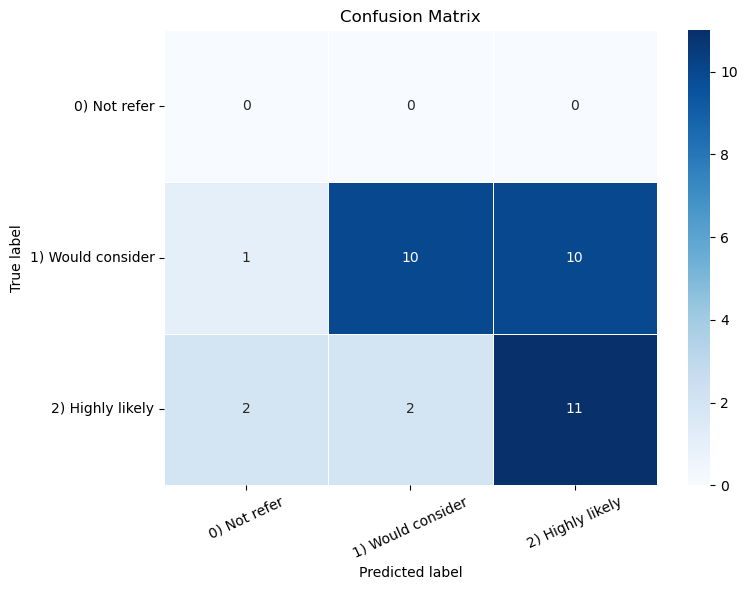


Sample of omitted rows (no match_verdict):


,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
3,sigir-20141,NCT00005757,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,sigir-20141,NCT00129233,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,sigir-20141,NCT00162344,1,A Study of Stress Heart Imaging in Patients With Diabetes at Risk for Coronary Disease.,None,None,None,PASS,"Patient does not meet any exclusion criteria. The patient's chest pain is episodic and triggered by walking, which does not clearly indicate ""typical chest pain"" as defined in the exclusion criter...",FAIL,None,- History of diabetes for at least 5 years,"The trial requires a history of diabetes for at least 5 years, along with at least 2 risk factors and atypical chest pain. The patient's medical history does not mention diabetes, which is a cruci...",NaN,1
12,sigir-20141,NCT00479908,1,Blood Pressure Interaction Between Sildenafil and Sublingual Glyceryl Trinitrate (GTN) in Men With Angina,None,None,None,PASS,"Patient does not meet any exclusion criteria. Although the patient presents with episodic chest pain suggestive of angina and has a history of hypertension, there is no clear evidence that she mee...",FAIL,"None\nUNMET CRITERIA: \n- Male: The patient is female, which does not meet the gender criterion.\n- Weight between 60 and 100 Kg: The patient's weight is not mentioned, but the patient is describe...","- Male: The patient is female, which does not meet the gender criterion.\n- Weight between 60 and 100 Kg: The patient's weight is not mentioned, but the patient is described as having obesity, whi...","The primary reason for the FAIL verdict is that the patient is female, while the trial specifically includes males. Although other criteria such as weight and specific diagnostic evidence of CAD o...",NaN,1
15,sigir-20141,NCT00802230,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [8]:
labels = [0, 1, 2]
label_names = [
    "0) Would not refer",
    "1) Would consider referral (needs investigation)",
    "2) Highly likely to refer"
]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd

verdict_map = {
    "STRONG MATCH": 2,
    "POSSIBLE MATCH": 2,
    "WEAK MATCH": 1,
    "UNSUITABLE": 0
}
merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map)
merged_df['true_label'] = merged_df['score_x']

labels = [0, 1, 2]
label_names = [
    "0) Not refer",
    "1) Would consider",
    "2) Highly likely"
]

n_missing = merged_df['match_verdict'].isna().sum()
print(f"Rows with missing match_verdict (excluded from evaluation): {n_missing}")

eval_df = merged_df[~merged_df['predicted_label'].isna() & ~merged_df['true_label'].isna()]
y_true = eval_df['true_label'].astype(int)
y_pred = eval_df['predicted_label'].astype(int)

cm = confusion_matrix(y_true, y_pred, labels=labels)
f1 = f1_score(y_true, y_pred, labels=labels, average='macro')

print("\nConfusion matrix (table):\n")
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
display(cm_df)

print("\nMacro F1 score: {:.4f}".format(f1))
print("\nDetailed classification report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=label_names))

# Blue Confusion Matrix Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# Show omitted rows if any
if n_missing > 0:
    print("\nSample of omitted rows (no match_verdict):")
    display(merged_df[merged_df['match_verdict'].isna()].head())

In [9]:
# Set pandas display options 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 600)

In [10]:
display(merged_df)

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
0,sigir-20141,NCT00000492,1,Beta-Blocker Heart Attack Trial (BHAT),20,UNSUITABLE,"The patient's profile does not align well with the requirements of the Beta-Blocker Heart Attack Trial (BHAT) primarily because there is no documented history of myocardial infarction, a critical inclusion criterion. The trial focuses on secondary prevention in patients who have had at least one documented myocardial infarction, aiming to reduce mortality from all causes. The patient's current presentation of chest pain, while concerning for cardiac issues, does not meet the specific disease alignment required for the trial. Furthermore, the lack of detailed information about the patient's...",PASS,No exclusion criteria specified,UNDETERMINED,None,None,No inclusion criteria specified,0.0,1
1,sigir-20141,NCT00005127,2,Muscatine Heart Study,20,UNSUITABLE,"The patient's profile does not align well with the Muscatine Heart Study's requirements for several key reasons. Firstly, the study's design is both cross-sectional and longitudinal, focusing on the development of coronary risk factors from childhood into adulthood. The patient, at 58 years old, is being considered outside the context of this longitudinal follow-up, which is a major disqualifying factor. Secondly, while the patient has hypertension, a condition relevant to the study, the trial's emphasis is on understanding how risk factors in childhood predict adult cardiovascular disease...",PASS,No exclusion criteria specified,UNDETERMINED,None,None,No inclusion criteria specified,0.0,2
2,sigir-20141,NCT00005485,2,Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans,80,STRONG MATCH,"The patient presents with symptoms suggestive of cardiovascular disease and has a history of hypertension, which is a key risk factor for the conditions being studied in the trial. The alignment of the patient's demographic profile (African American) with the trial's inclusion criteria is a significant positive factor. While there are concerns regarding the lack of detailed biomarker or genetic information, the patient's clinical presentation and existing conditions suggest a strong potential match for the trial's objectives. The trial's focus on understanding and addressing the disproport...",PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient's demographics indicate that she is African-American, which directly aligns with the trial's sole inclusion criterion of being African American. Since this criterion is met without any ambiguity or missing information that would contradict her eligibility, the patient can be included in the trial based on the provided information.",2.0,2
3,sigir-20141,NCT00005757,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,sigir-20141,NCT00129233,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,sigir-201410,NCT02264964,1,Duration and Adverse Events of Non-cuffed Catheter in Patients With Hemodialysis,None,None,None,EXCLUDE,"The patient has a recent medical history of cardiac catheterization via the right femoral artery, which implies that a central venous puncture or catheterization has been performed before, thus meeting the first exclusion criterion: ""Had been performed central venous puncture or catheterization before."" This is clear evidence that the patient should be excluded from the trial based on their medical history.",None,None,None,None,NaN,1
55,sigir-201410,NCT02389023,1,Comparison of Prevena Negative Pressure Incision Management System vs. Standard Dressing After Vascular Surgery,None,None,None,EXCLUDE,"The patient meets exclusion criterion 1: ""Any groin incision on index leg within 12 weeks prior to treatment initiation."" The p